<a href="https://colab.research.google.com/github/kumarneeraj2005/2048-Deep-Learning/blob/master/maskRcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd
  
!git clone --quiet https://github.com/matterport/Mask_RCNN.git

/root


In [2]:
%cd Mask_RCNN/

/root/Mask_RCNN


In [0]:
!pip install -q PyDrive

In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 204kB 4.8MB/s 


In [5]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/m

In [6]:
%cd ~/Mask_RCNN

/root/Mask_RCNN


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

https://drive.google.com/file/d/1mwZBVAWa3V7HblHjrxKyh91RaNBY9Npy/view?usp=sharing

In [10]:
fileId = '1mwZBVAWa3V7HblHjrxKyh91RaNBY9Npy'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

os.makedirs('dataset')
os.chdir('dataset')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

Extracted zip file 1mwZBVAWa3V7HblHjrxKyh91RaNBY9Npy.zip


# New Section

In [11]:
%cd ~/Mask_RCNN

!cp ~/Mask_RCNN/samples/balloon/balloon.py ./dog.py

!sed -i -- 's/balloon/dog/g' dog.py
!sed -i -- 's/Balloon/Dog/g' dog.py
!sed -i -- 's/epochs=30/epochs=5/g' dog.py

/root/Mask_RCNN


In [12]:
%cd ~/Mask_RCNN

!python dog.py train --dataset=dataset/ --weights=coco

/root/Mask_RCNN
Using TensorFlow backend.
Weights:  coco
Dataset:  dataset/
Logs:  /logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_

In [13]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import dog

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

custom_WEIGHTS_PATH = sorted(glob.glob("/logs/*/mask_rcnn_*.h5"))[-1]

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

config = dog.DogConfig()
custom_DIR = os.path.join(ROOT_DIR, "dataset")

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
  
# Load validation dataset
dataset = dog.DogDataset()
dataset.load_dog(custom_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Using TensorFlow backend.


Instructions for updating:
Use tf.cast instead.
Loading weights  /logs/dog20190601T1838/mask_rcnn_dog_0005.h5
Re-starting from epoch 5


<module 'mrcnn.visualize' from '/root/Mask_RCNN/mrcnn/visualize.py'>

image ID: dog.dog_002.jpg (0) /root/Mask_RCNN/dataset/val/dog_002.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  187.00000  max:  683.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
image ID: dog.dog_016.jpg (1) /root/Mask_RCNN/dataset/val/dog_016.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.7

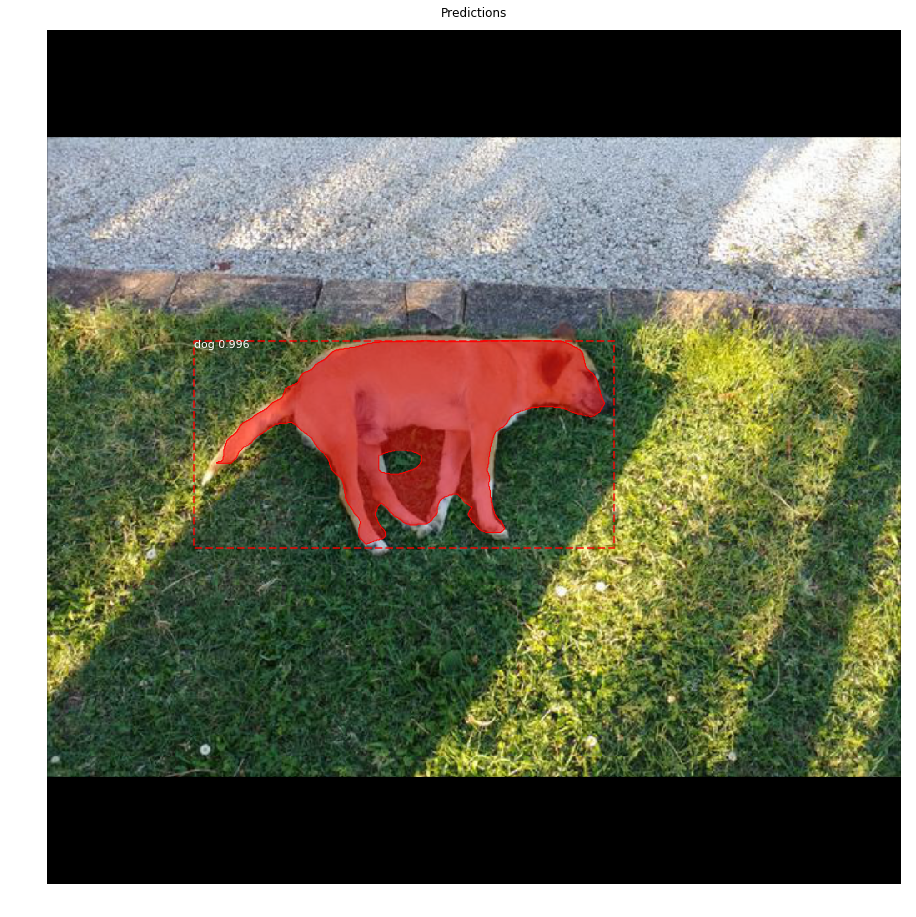

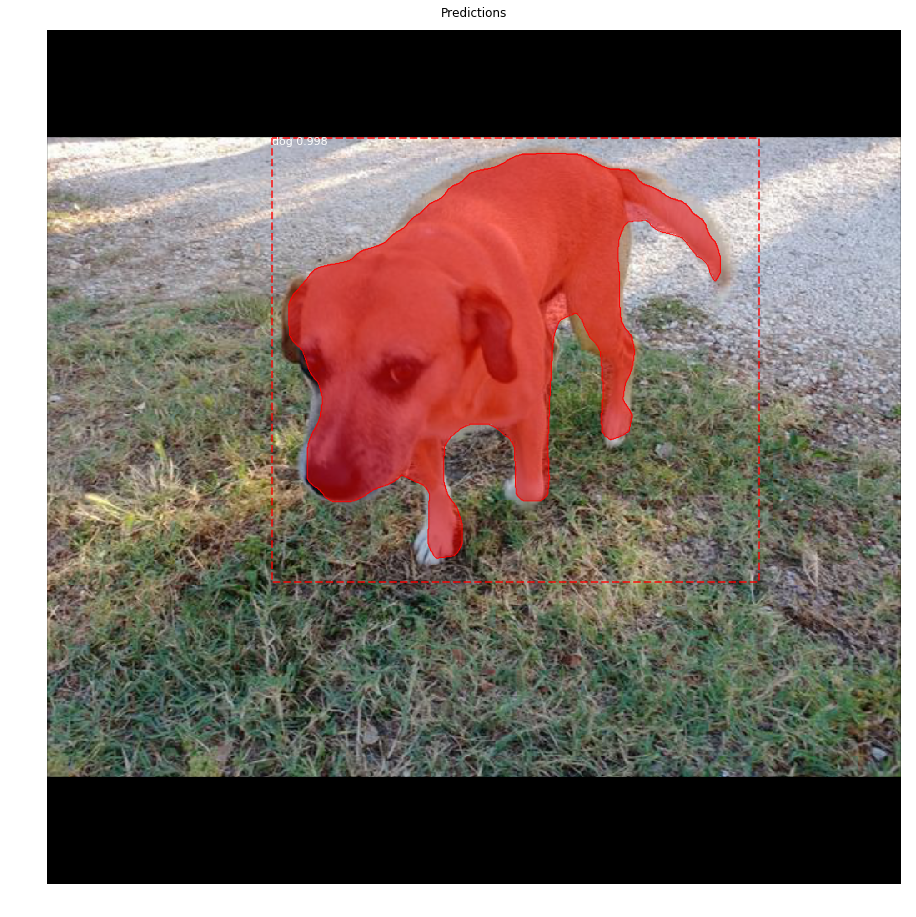

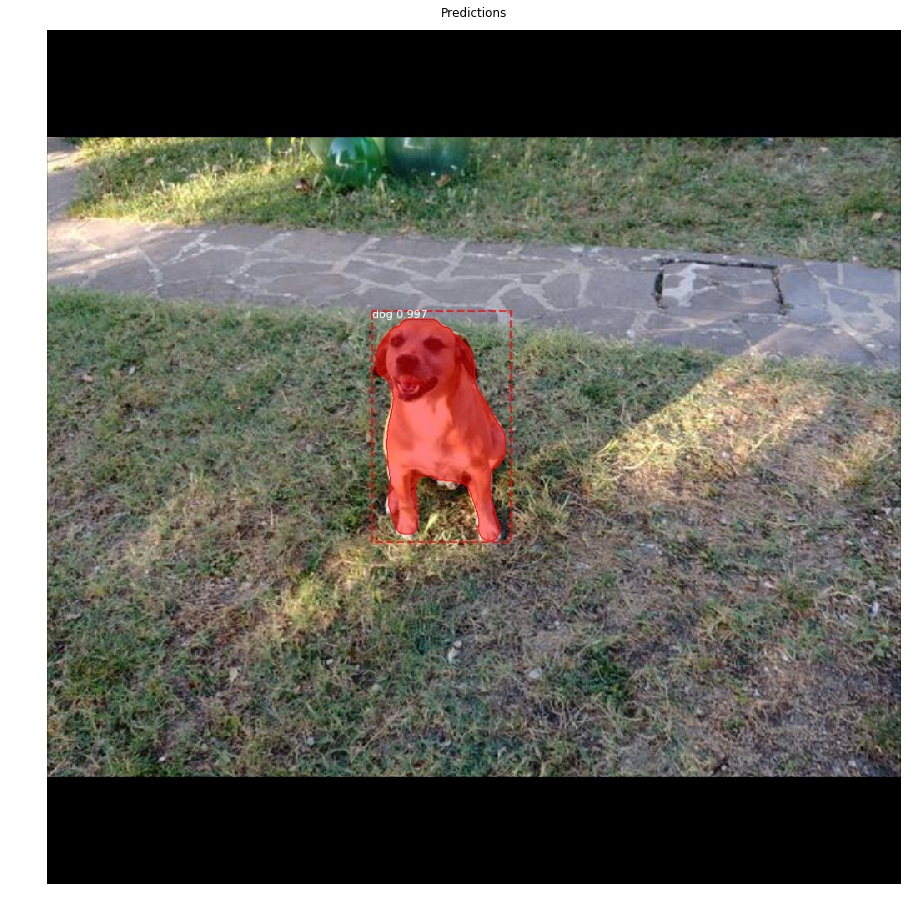

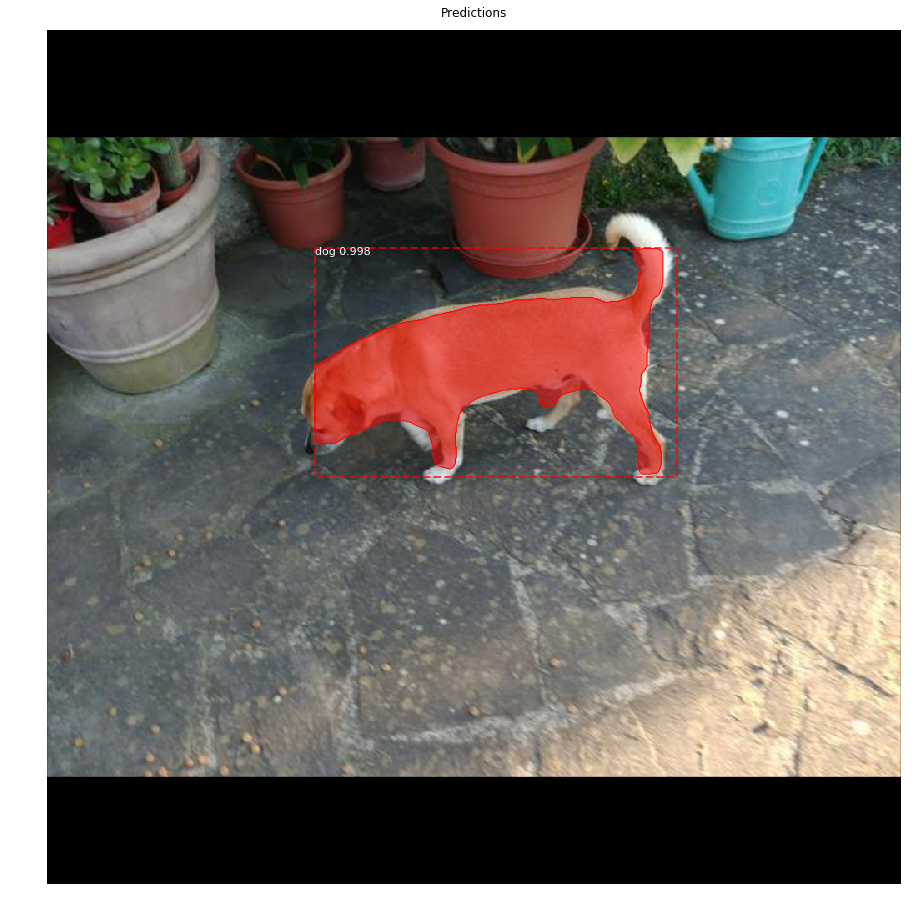

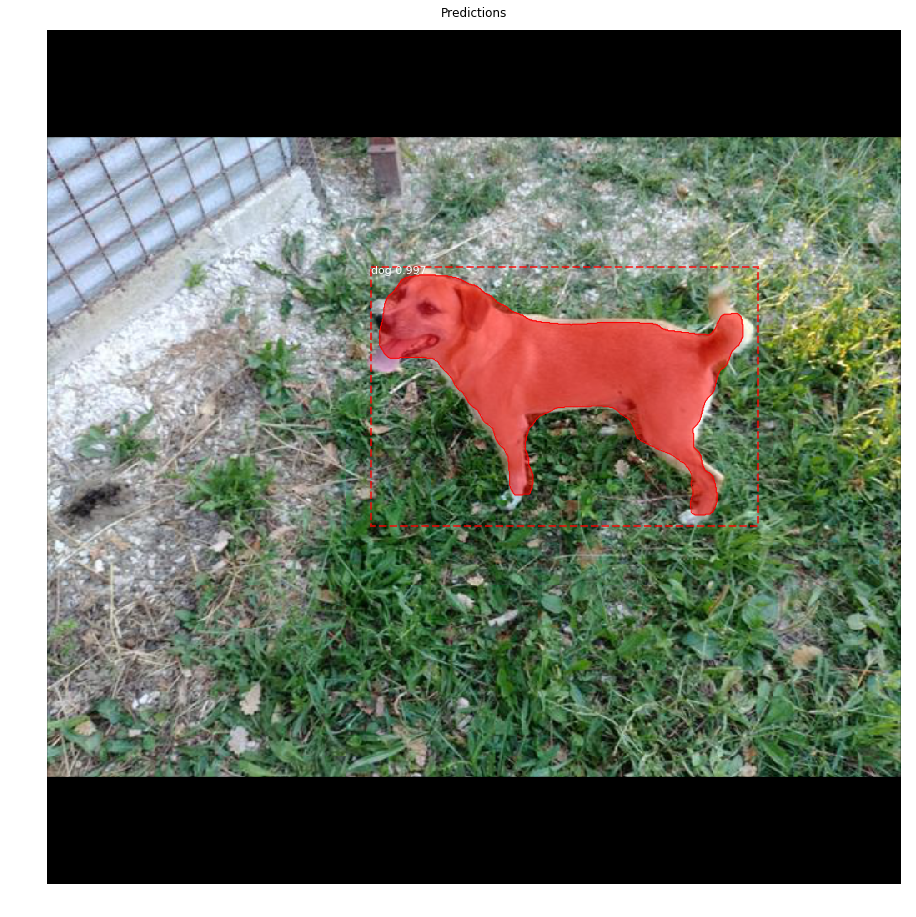

In [14]:
for image_id in dataset.image_ids:
  image, image_meta, gt_class_id, gt_bbox, gt_mask =\
      modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
  info = dataset.image_info[image_id]
  print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                         dataset.image_reference(image_id)))

  # Run object detection
  results = model.detect([image], verbose=1)

  # Display results
  ax = get_ax(1)
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              dataset.class_names, r['scores'], ax=ax,
                              title="Predictions")
  log("gt_class_id", gt_class_id)
  log("gt_bbox", gt_bbox)
  log("gt_mask", gt_mask)